In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [3]:

# 1. Data Collection

# Load historical data for USD/JPY, EUR/USD, GBP/USD, 10Y and 30Y Treasury
usd_jpy = yf.download('JPY=X', start='2010-01-01', end='2023-12-31')['Close']
eur_usd = yf.download('EURUSD=X', start='2010-01-01', end='2023-12-31')['Close']
gbp_usd = yf.download('GBPUSD=X', start='2010-01-01', end='2023-12-31')['Close']
treasury_10y = yf.download('^TNX', start='2010-01-01', end='2023-12-31')['Close']
treasury_30y = yf.download('^TYX', start='2010-01-01', end='2023-12-31')['Close']

# Calculate the 10Y-30Y yield spread
yield_spread = treasury_10y - treasury_30y

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'USD/JPY': usd_jpy,
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread
})

# Drop any rows with missing values
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:

# 2. Data Preprocessing

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and test sets
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Create the dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        X.append(a)
        y.append(dataset[i + time_step, 0])  # Predicting USD/JPY (index 0)
    return np.array(X), np.array(y)

time_step = 60  # 60 days of historical data
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the data for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [5]:

# 3. Model Definition

def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=25))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [6]:

# 4. Hyperparameter Tuning

# Wrap the model with KerasRegressor from SciKeras
model = KerasRegressor(model=create_model, verbose=0)

In [7]:

# Define the hyperparameter grid
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

In [8]:

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__units': 100, 'optimizer': 'adam'}
Best Score: 0.9285682331706947


In [14]:

# 5. Model Training and Prediction

# Retrieve the best model
best_model = grid_result.best_estimator_

# Predict using the best model
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

# Inverse transform to get actual values
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_target.min_, scaler_target.scale_ = scaler.min_[0], scaler.scale_[0]

train_predict = scaler_target.inverse_transform(train_predict.reshape(-1, 1)).flatten()
test_predict = scaler_target.inverse_transform(test_predict.reshape(-1, 1)).flatten()
y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

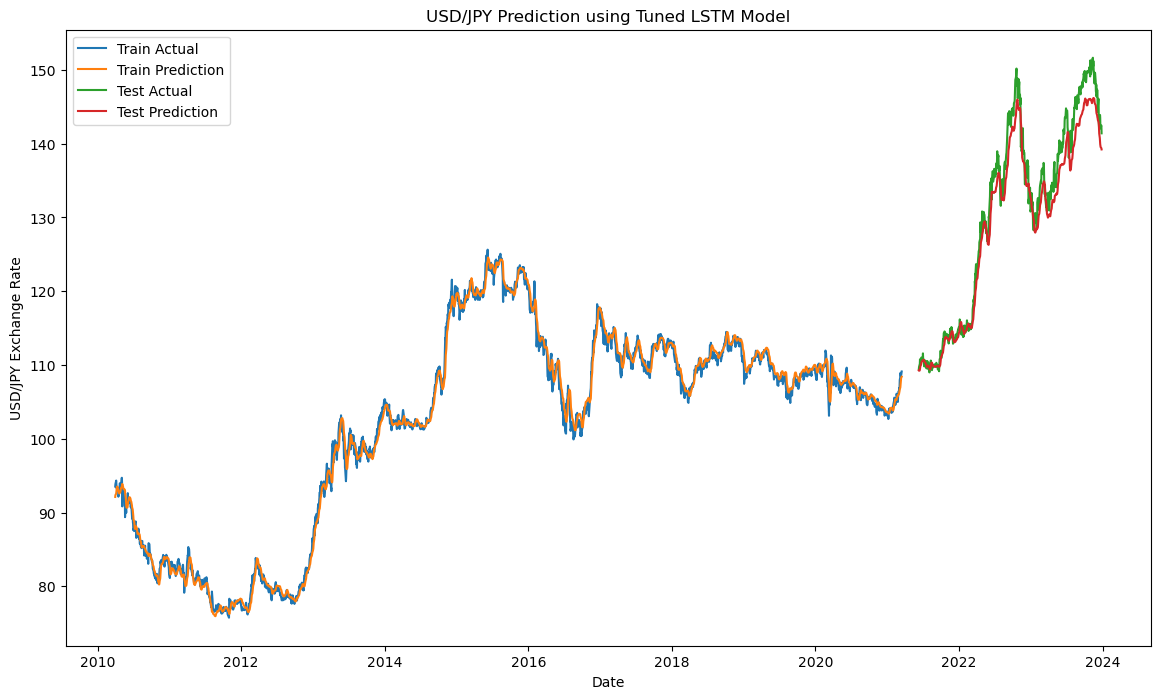

In [15]:

# 6. Visualization

# Adjust the index ranges for plotting
train_plot_range = data.index[time_step:time_step + len(y_train_actual)]
test_plot_range = data.index[time_step + len(y_train_actual) + time_step:time_step + len(y_train_actual) + time_step + len(y_test_actual)]

# Plot the results
plt.figure(figsize=(14,8))
plt.plot(train_plot_range, y_train_actual, label='Train Actual')
plt.plot(train_plot_range, train_predict, label='Train Prediction')
plt.plot(test_plot_range, y_test_actual, label='Test Actual')
plt.plot(test_plot_range, test_predict, label='Test Prediction')
plt.title('USD/JPY Prediction using Tuned LSTM Model')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()


In [16]:
# Do precision and recall analysis
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train_actual, train_predict, squared=False)
test_rmse = mean_squared_error(y_test_actual, test_predict, squared=False)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")



Train RMSE: 1.0322116044000558
Test RMSE: 2.479394278624843


D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
# Now get 2024 data and predict the USD/JPY exchange rate
usd_jpy_2024 = yf.download('JPY=X', start='2024-01-01', end='2024-12-31')['Close']
# remove any missing values
usd_jpy_2024.dropna(inplace=True)

print(usd_jpy_2024)




[*********************100%***********************]  1 of 1 completed

Date
2024-01-01    140.951996
2024-01-02    141.126007
2024-01-03    142.154999
2024-01-04    142.998993
2024-01-05    144.764999
                 ...    
2024-08-23    146.201996
2024-08-26    144.000000
2024-08-27    144.516006
2024-08-28    143.975006
2024-08-29    144.432999
Name: Close, Length: 174, dtype: float64


In [ ]:

# Plot the results
plt.figure(figsize=(14,8))
plt.plot(data_2024.index, data_2024['USD/JPY_2024'], label='Actual')
plt.plot(data_2024.index, predict_2024, label='Prediction')
plt.title('USD/JPY Prediction for 2024 using Tuned LSTM Model')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()

